# Random Forest- tuning parameters and cross validation
See <a href="https://www.kaggle.com/dansbecker/random-forests">Random Forests</a> tutorial from Kaggle's excellent (and short) <a href="https://www.kaggle.com/learn/intro-to-machine-learning">Intro to Machine Learning</a> course 

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import pandas as pd
import numpy as np

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Set max rows and columns displayed in jupyter
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

#the following gives access to utils folder
#where utils package stores shared code
import os
import sys
PROJECT_ROOT = os.path.abspath(os.path.join(
                  os.getcwd(),
                  os.pardir)
)

#only add it once
if (PROJECT_ROOT not in sys.path):
    sys.path.append(PROJECT_ROOT)

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Load Data


In [22]:
df = pd.read_csv("../datasets/melb_data.csv")
df.head()
print(f'there are {len(df)} rows in df')

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,3.0,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


there are 13580 rows in df


## Preprocessing
Don't have to do much for random forest.  Gotta handle nulls though

In [23]:
df.isnull().sum()
# df.dtypes
# # df.nunique() #use to find columns that help distinguish areas
# df.describe()

Suburb              0
Address             0
Rooms               0
Type                0
Price               0
Method              0
SellerG             0
Date                0
Distance            0
Postcode            0
Bedroom2            0
Bathroom            0
Car                62
Landsize            0
BuildingArea     6450
YearBuilt        5375
CouncilArea      1369
Lattitude           0
Longtitude          0
Regionname          0
Propertycount       0
dtype: int64

In [24]:
#what percentage of rows have a null?
numb_nulls=(df.BuildingArea.isnull() | df.YearBuilt.isnull()).sum()
print(f'Total number rows with at least 1 null={numb_nulls}, or {(numb_nulls/len(df))*100:.3f} percent')
numb_nulls2=(df.BuildingArea.isnull() & df.YearBuilt.isnull()).sum()
print(f'Total number rows with 2 nulls={numb_nulls2}, or {(numb_nulls2/len(df))*100:.3f} percent')

Total number rows with at least 1 null=6722, or 49.499 percent
Total number rows with 2 nulls=5103, or 37.577 percent


### You could be lazy and just use the column mean

In [21]:
# df.BuildingArea=df.BuildingArea.fillna(value=df.BuildingArea.mean())
# df.YearBuilt=df.YearBuilt.fillna(value=df.YearBuilt.mean())

### There are a LOT of nulls, so many that I hesitate to approximate them
Or... we could take the column average

Or... we could take the average for the neighborhood

Or... we could come up with a heuristic to approximate them, (BuildingArea average for suburb) + standard_dev*( (RoomsAv-Rooms)/RoomsAv + (BathroomAv-Bathroom)/BathroomAv ...  ), a bit fiddly

Or... we could build a model to estimate them

### the column average for buildingarea
not very accurate given the high std

In [25]:
BuildingAreaAv = df.BuildingArea.mean()
print(f' BuildingAreaAv={BuildingAreaAv}')
print(f' BuildingAreaStd={df.BuildingArea.std()}')

 BuildingAreaAv=151.96764988779805
 BuildingAreaStd=541.0145376263513


### Lets just use the average for the particular suburb for the columns with missing data

In [27]:
# get the columns of interest
cols=[x for x,y in df.isnull().sum().items() if y>0 ]
cols.remove('CouncilArea')
print(cols)

# get all avaerages by suberb
av = df.groupby(by='Suburb').mean()
av.head()

#get the ones with nulls

for col in cols:
    def fun(ds,col):
        if(np.isnan(ds[col])):
            ds[col] = av.loc[ds['Suburb'],col]
        return ds
    
    df=df.apply(fun,col=col, axis=1)
df.head()

['BuildingArea', 'YearBuilt']


,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
Suburb,,,,,,,,,,,,,
Abbotsford,2.410714,1.060366e+06,2.616071,3067.0,2.410714,1.410714,0.946429,292.446429,103.000000,1945.184211,-37.804339,144.997176,4019.0
Aberfeldie,3.090909,1.277455e+06,8.627273,3040.0,3.000000,1.863636,1.977273,514.772727,163.692000,1979.100000,-37.759280,144.897587,1543.0
Airport West,3.000000,7.566567e+05,12.482090,3042.0,2.865672,1.477612,1.641791,432.880597,135.272895,1984.476190,-37.723399,144.879635,3464.0
Albanvale,3.000000,5.370833e+05,14.000000,3021.0,3.000000,1.333333,2.166667,501.166667,123.000000,1980.000000,-37.745640,144.770878,1899.0
Albert Park,2.710145,1.941355e+06,3.230435,3206.0,2.666667,1.434783,0.727273,176.652174,123.485294,1903.756757,-37.844127,144.953107,3280.0


,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,103.0,1945.184211,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.000000,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.000000,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,1.0,94.0,103.0,1945.184211,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,3.0,1.0,2.0,120.0,142.0,2014.000000,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


### Oh no there are still some NaNs
these are null since all entries for them were null

In [ ]:
# _=df[df.BuildingArea.isnull()]
# #these are null since all entries for them were null
# df[df.Suburb=='Rockbank']

# df.isnull().sum()

### If have no data then just use column mean, or drop the rows

In [28]:
#OK not much to do here
#either delete, and lose any info for those suburbs :(
#or take a guess

df.BuildingArea=df.BuildingArea.fillna(value=df.BuildingArea.mean())
df.YearBuilt=df.YearBuilt.fillna(value=df.YearBuilt.mean())

### Save preprocessed info

In [29]:
df.to_feather("melb_data.feather")
#reload

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,103.0,1945.184211,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.000000,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.000000,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,1.0,94.0,103.0,1945.184211,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,3.0,1.0,2.0,120.0,142.0,2014.000000,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


In [42]:
df=pd.read_feather("melb_data.feather")
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,103.0,1945.184211,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.000000,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.000000,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,1.0,94.0,103.0,1945.184211,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,3.0,1.0,2.0,120.0,142.0,2014.000000,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


## BTW if you are doing EDA or model building AND your dataset is large then work with a randomly sampled fraction of the data.

This will hugely speed up EDA and model training.  You should do this every time when you first start working with a dataset, especially if it's a large one.

<mark>When you finish tuning, finding hyperparameters and such, then train on the FULL dataset

In [43]:
#sample, then clean up index
df=df.sample( frac=.2, replace=False, weights=None, random_state=42).reset_index(drop=True)
print(f'there are {len(df)} rows in df')

there are 13580 rows in df


## Lets strip some columns to make this demo easier

In [60]:
df.nunique()

Suburb             314
Address          13378
Rooms                9
Type                 3
Price             2204
Method               5
SellerG            268
Date                58
Distance           202
Postcode           198
Bedroom2            12
Bathroom             9
Car                 45
Landsize          1448
BuildingArea       835
YearBuilt          365
CouncilArea         33
Lattitude         6503
Longtitude        7063
Regionname           8
Propertycount      311
dtype: int64

In [59]:
df.columns

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname', 'Propertycount'],
      dtype='object')

In [62]:
#lets strip out just a few columns to make this example easier
# Choose target and features
features = ['Suburb','Rooms','Type','Method','Distance','Postcode', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 
                        'YearBuilt', 'Lattitude', 'Longtitude']
#original
# features = ['Rooms', 'Bathroom', 'Landsize', 'BuildingArea', 
#                         'YearBuilt', 'Lattitude', 'Longtitude']
X = df[features]
y = df.Price
print(f'there are {len(df)} rows in X')
X.head()

there are 13580 rows in X


,Suburb,Rooms,Type,Method,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude
0,Brighton,3,h,S,11.2,3186.0,3.0,2.0,3.0,588.0,197.558222,1961.807692,-37.9287,144.9920
1,West Melbourne,2,u,S,1.9,3003.0,2.0,1.0,1.0,0.0,83.000000,2002.000000,-37.8091,144.9520
2,St Kilda,3,u,SP,6.1,3182.0,3.0,1.0,0.0,0.0,115.000000,1930.000000,-37.8718,144.9767
3,Pascoe Vale,3,t,VB,9.9,3044.0,3.0,2.0,1.0,146.0,106.000000,2006.000000,-37.7152,144.9346
4,South Kingsville,2,h,SP,9.1,3015.0,2.0,1.0,2.0,462.0,124.090909,1970.000000,-37.8331,144.8715


In [67]:
# encode strings
from sklearn.preprocessing import LabelEncoder  

#Get list of categorical variables
s = (X.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)
#Label Encoding the object dtypes.
LE=LabelEncoder()
for i in object_cols:
    X[i]=X.loc[:,i].apply(LE.fit_transform)
    
print("All features are now numerical")

Categorical variables in the dataset: ['Suburb', 'Type', 'Method']
All features are now numerical


/tmp/ipykernel_22462/4213079410.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [68]:
X.head()

,Suburb,Rooms,Type,Method,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude
0,41,3,0,1,11.2,3186.0,3.0,2.0,3.0,588.0,197.558222,1961.807692,-37.9287,144.9920
1,300,2,2,1,1.9,3003.0,2.0,1.0,1.0,0.0,83.000000,2002.000000,-37.8091,144.9520
2,266,3,2,3,6.1,3182.0,3.0,1.0,0.0,0.0,115.000000,1930.000000,-37.8718,144.9767
3,229,3,1,4,9.9,3044.0,3.0,2.0,1.0,146.0,106.000000,2006.000000,-37.7152,144.9346
4,256,2,0,3,9.1,3015.0,2.0,1.0,2.0,462.0,124.090909,1970.000000,-37.8331,144.8715


# Split data, create a random forest classifier, use default hyperparameters to get a baseline

## Get train/test split

In [69]:
# split data into training and validation data, for both features and target
# The split is based on a random number generator. Supplying a numeric value to
# the random_state argument guarantees we get the same split every time we
# run this script.
from sklearn.model_selection import train_test_split
train_X, val_X, train_y, val_y = train_test_split(X, y,random_state = 0)

## Baseline model

In [70]:
from sklearn.metrics import mean_absolute_error
def evalmodel(model,X,y):
    '''
    just prints mean_absolute_error
    '''
    preds = model.predict(X)
    mae=mean_absolute_error(y, preds)
    print(mae)
    return mae

In [71]:
%%time
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=42)
_=model.fit(train_X, train_y)

base_mae=evalmodel(model,val_X,val_y)

164267.85859555367
CPU times: user 3.93 s, sys: 10.6 ms, total: 3.94 s
Wall time: 3.94 s


In [74]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

## What hyperparameters can I tune to make this model better?

In [ ]:
# model.get_params()

 lets do max_depth min_samples_split, min_samples_leaf and n_estimators

## Use Optuna to tune hyperparameters

In [ ]:
# !conda install -c conda-forge optuna -y

In [72]:
%%time
import optuna
import sklearn
def objective(trial,X=X,y=y):
    
    #these are the parameters I want to optimize
    n_estimators = trial.suggest_int('n_estimators', 10, 100)
    max_depth = int(trial.suggest_int('max_depth', 1, 32))
    min_samples_split = int(trial.suggest_int('min_samples_split', 2, 10))
    min_samples_leaf= int(trial.suggest_int('min_samples_leaf', 1, 10))

    # Define the model. Pass in params to be tuned
    clf = RandomForestRegressor(random_state=42, n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf )  

    #get the cross validation score
    return sklearn.model_selection.cross_val_score( clf, X, y, n_jobs=-1, cv=3, scoring='neg_mean_absolute_error').mean() 
 
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)

trial = study.best_trial

print('neg_mean_absolute_error: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))
    

[I 2022-03-18 02:07:37,561] A new study created in memory with name: no-name-b26a6f04-7707-41bb-b275-a89399626fad
[I 2022-03-18 02:07:39,218] Trial 0 finished with value: -170003.65087684768 and parameters: {'n_estimators': 37, 'max_depth': 21, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 0 with value: -170003.65087684768.
[I 2022-03-18 02:07:41,597] Trial 1 finished with value: -172612.3939562655 and parameters: {'n_estimators': 78, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 8}. Best is trial 0 with value: -170003.65087684768.
[I 2022-03-18 02:07:44,144] Trial 2 finished with value: -170031.3676436806 and parameters: {'n_estimators': 77, 'max_depth': 13, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 0 with value: -170003.65087684768.
[I 2022-03-18 02:07:46,464] Trial 3 finished with value: -180992.60857260774 and parameters: {'n_estimators': 92, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 0 with val

neg_mean_absolute_error: -166885.62433073565
Best hyperparameters: {'n_estimators': 59, 'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 2}
CPU times: user 457 ms, sys: 255 ms, total: 713 ms
Wall time: 49.3 s


In [92]:
#want to rerun picking up where we left off?
study.optimize(objective, n_trials=25)

[I 2022-03-18 02:22:33,000] Trial 75 finished with value: -166545.30319367698 and parameters: {'n_estimators': 81, 'max_depth': 21, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 64 with value: -166497.24448881613.
[I 2022-03-18 02:22:35,712] Trial 76 finished with value: -167714.28530015665 and parameters: {'n_estimators': 83, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 64 with value: -166497.24448881613.
[I 2022-03-18 02:22:38,194] Trial 77 finished with value: -166847.1905484462 and parameters: {'n_estimators': 80, 'max_depth': 21, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 64 with value: -166497.24448881613.
[I 2022-03-18 02:22:40,959] Trial 78 finished with value: -166799.82113221128 and parameters: {'n_estimators': 87, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 64 with value: -166497.24448881613.
[I 2022-03-18 02:22:43,555] Trial 79 finished with value: -168018.3555060747 and 

In [93]:
#what are the best parameters
trial = study.best_trial
trial.params

{'n_estimators': 89,
 'max_depth': 22,
 'min_samples_split': 5,
 'min_samples_leaf': 2}

## Lets see how a model with optimized parameters performs compared to the baseline above

In [95]:
# model = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=18, min_samples_split=3, min_samples_leaf=2)
# model = RandomForestRegressor(random_state=42, n_estimators=88, max_depth=21, min_samples_split=5, min_samples_leaf=2)
model=RandomForestRegressor(random_state=42, **trial.params)
_=model.fit(train_X, train_y)

opt_mae=evalmodel(model,val_X,val_y)
print(f'percentage improvement over base_mae=%{((base_mae-opt_mae)/base_mae)*100}')

163879.07018106396
percentage improvement over base_mae=%0.23667954145975226


In [96]:
model.get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(max_depth=22, min_samples_leaf=2, min_samples_split=5,
                      n_estimators=89, random_state=42)>

# Optuna visualizations
see <a href="https://www.kaggle.com/bextuychiev/no-bs-guide-to-hyperparameter-tuning-with-optuna">this</a> page for an in depth exploration of Optuna.  

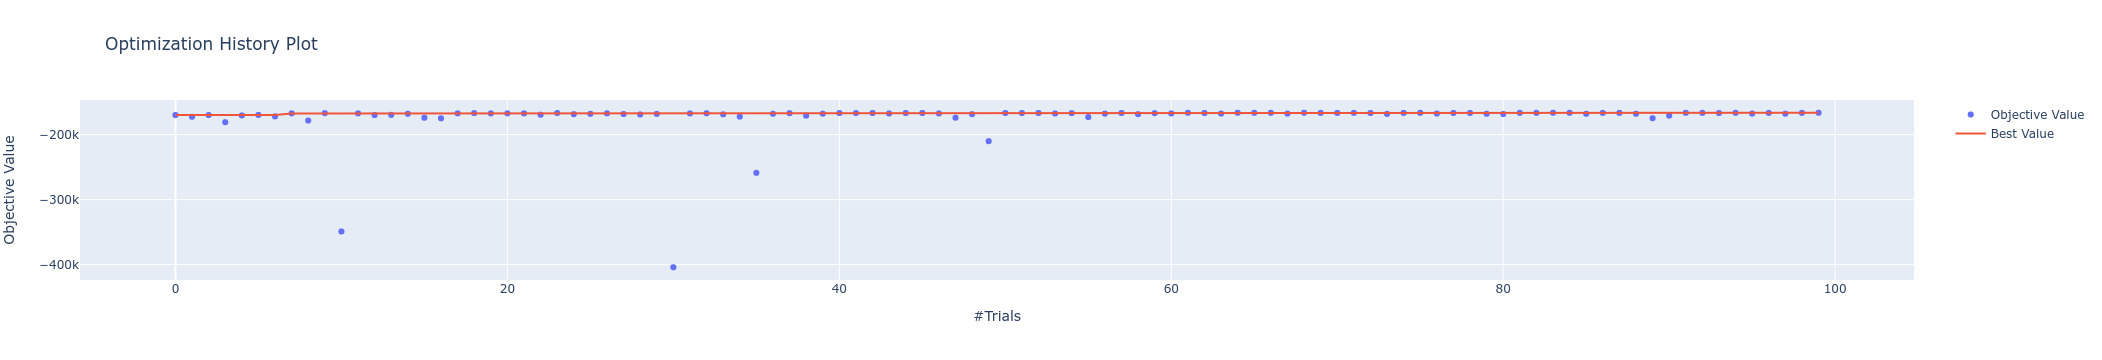

In [97]:
#lets see how long it took Optuna to get the best parameters
from optuna.visualization import plot_optimization_history

plotly_config = {"staticPlot": True}

fig = plot_optimization_history(study)
fig.show(config=plotly_config)

It found the best value very quickly

## What was the most important hyperparameters

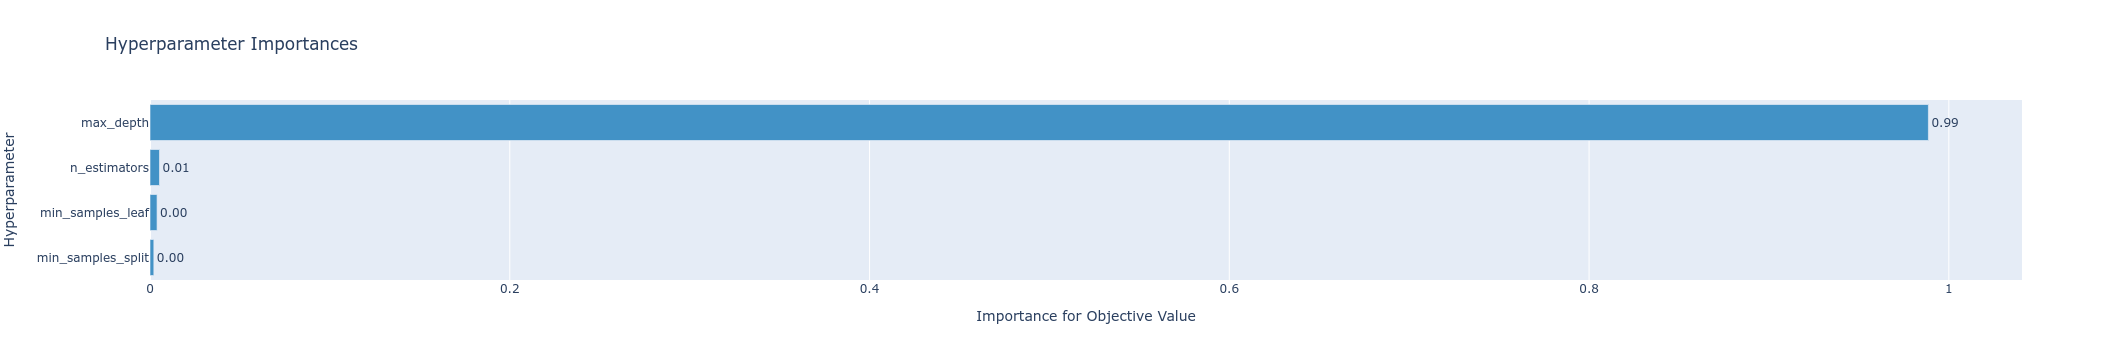

In [98]:
from optuna.visualization import plot_param_importances

fig = plot_param_importances(study)
fig.show(config=plotly_config)

Max depth is far and away the most important hyperparameter to change
 
A plot like this comes in handy when tuning models with many hyperparameters. For example, you could take a test run of 40–50 trials and plot the parameter importances.

Depending on the plot, you might decide to discard some less important parameters and give a larger search space for other ones, possibly reducing the search time and space.

You can check out <a href="https://optuna.readthedocs.io/en/stable/reference/visualization/index.html">this</a> page for more information on Optuna's supported plot types.

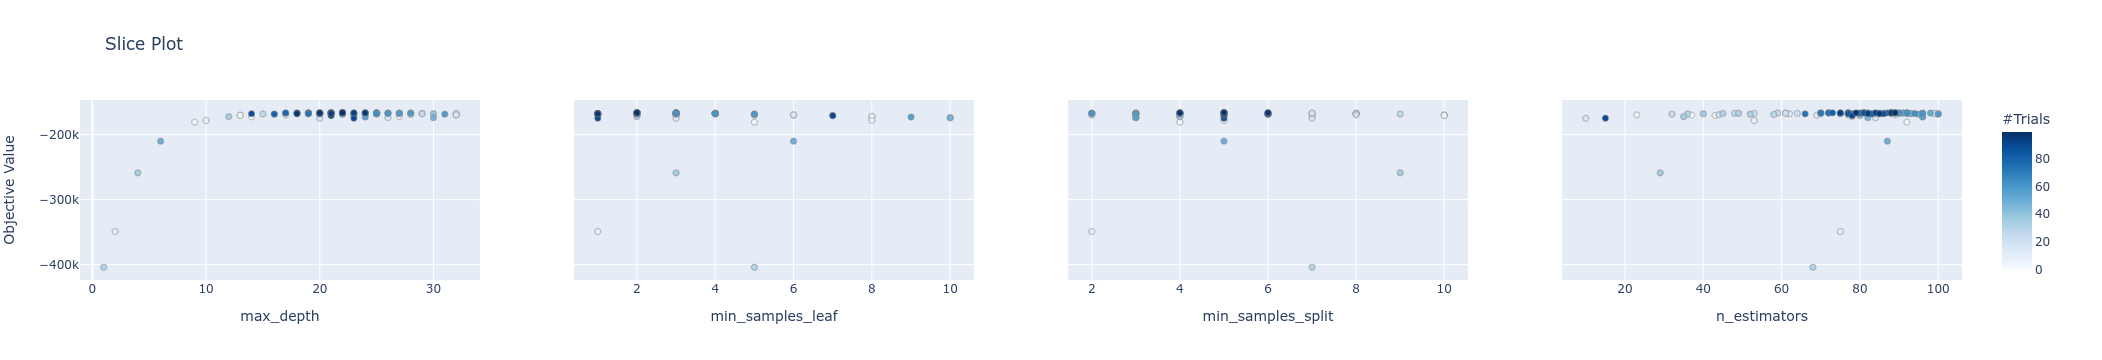

In [99]:
# Plotting the accuracies for each hyperparameter for each trial.
optuna.visualization.plot_slice(study)

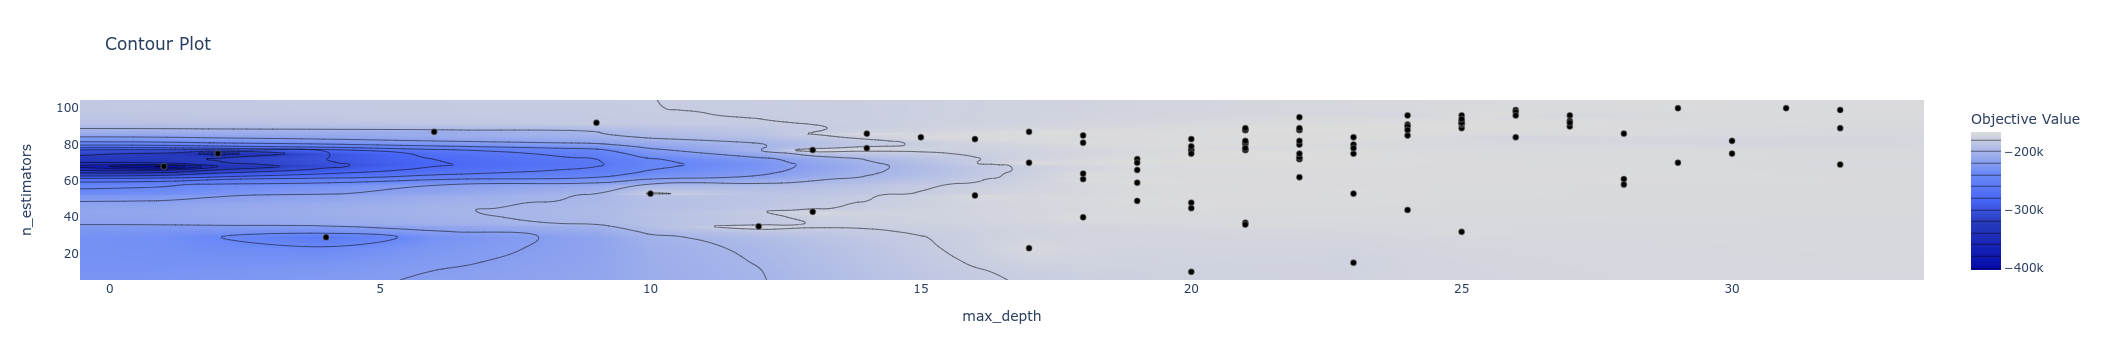

In [102]:
optuna.visualization.plot_contour(study, params=['n_estimators', 'max_depth'])

## Code for powerpoint slides

In [ ]:
# Define the model
clf = sklearn.ensemble.RandomForestRegressor()

#get the cross validation score
numb_folds=5
mae=sklearn.model_selection.cross_val_score(clf, train_X, train_y, cv=numb_folds, scoring='neg_mean_absolute_error').mean() 
print(f'The mean absolute error={mae}')